In [1]:
import warnings
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import dalex as dx
from modules.datakit import *
from scipy import stats
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, PredictionErrorDisplay
from sklearn.feature_selection import RFECV, RFE

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=FutureWarning)

__Read data__

In [145]:
path = f'data_processed/modeling_data.csv'
df = pd.read_csv(path)

columns_to_drop = ['latitude', 'longitude']
df.drop(columns=columns_to_drop, inplace=True)

__Input missing values__

In [147]:
input_missing_values(df)

In [155]:
df.loc[df.avg_price.ge(400), 'avg_price'] = 0

__One-Hot Encoding__

In [157]:
df_encoded = pd.get_dummies(
    df,
    columns=['heating', 'building_type', 'apartment_class'],
    prefix={'heating': 'heating', 'building_type': 'bt', 'apartment_class': 'ac'},
    prefix_sep='_',
    dtype=int)

district_dummies = pd.get_dummies(df['district'], prefix='', prefix_sep='', dtype=int)
df = pd.concat([df_encoded.drop('district', axis=1), district_dummies], axis=1)

__Calculate rental price along with additional fees__

In [160]:
df['rent'] = df['rent'] + df['additional_fees']
df.drop(columns=['additional_fees'], inplace=True)

__Split data into train and out of time sample__

In [163]:
train_df = df[df.added_dt.le('2025-01-25')].copy()
out_of_time_sample = df[df.added_dt.ge('2025-01-26')&df.added_dt.le('2025-02-04')].copy()

train_df.drop(columns=['added_dt'], inplace=True)
out_of_time_sample.drop(columns=['added_dt'], inplace=True)

__Split target and predictors__

In [166]:
y_col = 'rent'
x_cols = [col for col in train_df.columns if col != y_col]

X_train = train_df.drop([y_col], axis=1)
y_train = train_df[y_col]
X_out_of_time = out_of_time_sample.drop([y_col], axis=1)
y_out_of_time = out_of_time_sample[y_col]

__KFold for cross valdiation__

In [169]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

__First Cross Valdiation results (strongly overfitted)__

In [172]:
model = XGBRegressor()

cv_results = cross_validate(
    model, X_train, y_train, cv=cv,
    scoring=["neg_mean_absolute_error", "r2", "neg_mean_absolute_percentage_error"],
    return_train_score=True
)

print("MAE Train:", cv_results["train_neg_mean_absolute_error"])
print("MAE Test:", cv_results["test_neg_mean_absolute_error"])
print("Mean MAE Test:", cv_results["test_neg_mean_absolute_error"].mean())
print("-------------------")
print("R2 Train:", cv_results["train_r2"])
print("R2 Test:", cv_results["test_r2"])
print("Mean R2 Test:", cv_results["test_r2"].mean())
print("-------------------")
print("MAPE Train:", cv_results["train_neg_mean_absolute_percentage_error"])
print("MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"])
print("Mean MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"].mean())

MAE Train: [-123.55792503 -135.29800618 -127.89927365 -126.43817891 -133.13694704]
MAE Test: [-613.37914633 -616.17591549 -595.79890488 -633.0400837  -657.78116208]
Mean MAE Test: -623.2350424980523
-------------------
R2 Train: [0.99702439 0.99657383 0.99709213 0.99713144 0.99630265]
R2 Test: [0.90191495 0.8634473  0.85107156 0.87013209 0.89030453]
Mean R2 Test: 0.8753740842288048
-------------------
MAPE Train: [-0.02767007 -0.03028853 -0.02839997 -0.02806584 -0.02992072]
MAPE Test: [-0.11370635 -0.10699051 -0.11204548 -0.11863553 -0.11326237]
Mean MAPE Test: -0.1129280482711443


__Out of time performance - Non tuned model (strongly overfitted)__

In [174]:
model.fit(X_train, y_train)

y_pred_oot = model.predict(X_out_of_time)

mae_oot = mean_absolute_error(y_out_of_time, y_pred_oot)
r2_oot = r2_score(y_out_of_time, y_pred_oot)
mape_oot = mean_absolute_percentage_error(y_out_of_time, y_pred_oot)

print("Out-of-Time Sample Scores:")
print("MAE:", mae_oot)
print("R2:", r2_oot)
print("MAPE:", mape_oot)

Out-of-Time Sample Scores:
MAE: 594.7599245101686
R2: 0.843874166921335
MAPE: 0.12021195992423275


__Feature Selection - RFECV__

Optimal number of features: 38


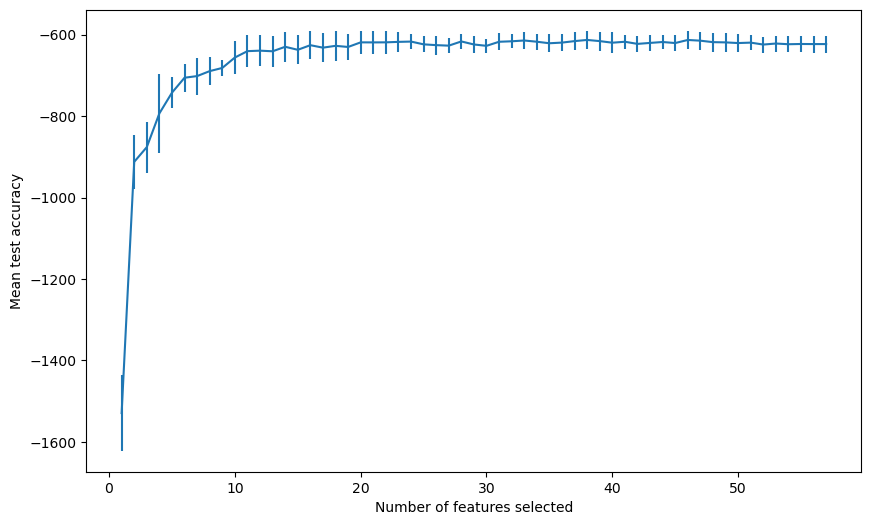

In [176]:
model = XGBRegressor()
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='neg_mean_absolute_error')
rfecv.fit(X_train, y_train)
print("Optimal number of features:", rfecv.n_features_)

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.show()

__Feature Selection - RFE__

In [178]:
model = XGBRegressor()
rfe = RFE(estimator=model, n_features_to_select=16, step=1)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print(f'Selected features: {str(list(selected_features))[1:-1]}')

Selected features: 'area', 'room_number', 'terrace', 'separate_kitchen', 'utility_room', 'building_age', 'air_conditioning', 'distance_to_subway', 'distance_to_center', 'avg_price', 'bt_tenement', 'ac_basic', 'ac_premium', 'ac_superior', 'Targowek', 'Wilanow'


__Hyperparameters Tuning - Grid Search__

In [180]:
param_grid = {
    "max_depth": [3],
    "learning_rate": [0.05],
    "n_estimators": [150],
    "subsample": [0.5],
    "colsample_bytree": [1],
    "min_child_weight": [3],
    "reg_alpha": [0],
    "reg_lambda": [1],
}

model = XGBRegressor()
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train[selected_features], y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score (Negative MAE):", grid_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.5}
Best CV score (Negative MAE): -595.5728183566698


In [82]:
param_grid = {
    "max_depth": np.arange(1, 4),
    "learning_rate": [0.0001, 0.001, 0.005, 0.01, 0.025, 0.05],
    "n_estimators": np.arange(50, 151, 25),
    "subsample": np.linspace(0.5, 1.0, 5),
    "colsample_bytree": np.linspace(0.5, 1.0, 5),
    "min_child_weight": np.arange(0, 10),
    "reg_alpha": np.linspace(0, 1.0, 5),
    "reg_lambda": np.linspace(0, 1.0, 5),
}

model = XGBRegressor()
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train[selected_features], y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score (Negative MAE):", grid_search.best_score_)

Fitting 5 folds for each of 562500 candidates, totalling 2812500 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 150, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.5}
Best CV score (Negative MAE): -595.1499181689318


In [34]:
best_model = grid_search.best_estimator_

__Train data performance - Tuned model__

In [182]:
y_pred_train = best_model.predict(X_train[selected_features])

mae_oot = mean_absolute_error(y_train, y_pred_train)
r2_oot = r2_score(y_train, y_pred_train)
mape_oot = mean_absolute_percentage_error(y_train, y_pred_train)

print("Train Sample Scores:")
print("MAE:", mae_oot)
print("R2:", r2_oot)
print("MAPE:", mape_oot)

Train Sample Scores:
MAE: 532.877448913067
R2: 0.9344042028215246
MAPE: 0.10299284232480242


__Out of time performance - Tuned model__

In [184]:
y_pred_oot = best_model.predict(X_out_of_time[selected_features])

mae_oot = mean_absolute_error(y_out_of_time, y_pred_oot)
r2_oot = r2_score(y_out_of_time, y_pred_oot)
mape_oot = mean_absolute_percentage_error(y_out_of_time, y_pred_oot)

print("Out-of-Time Sample Scores:")
print("MAE:", mae_oot)
print("R2:", r2_oot)
print("MAPE:", mape_oot)

Out-of-Time Sample Scores:
MAE: 560.4076051444215
R2: 0.8936311438519122
MAPE: 0.11753996216351875


<u>Note</u>: The model does not seem to be overfitted.<br> The differences between the training and out-of-time samples are relatively small.<br>MAE only increased by about 5% (from roughly 534 to 562), and the R² decreased slightly from 0.93 to 0.89. <br>These small changes are normal when moving from training data to new data, indicating that the model is generalizing well rather than memorizing the training data.

__Future Importnace__

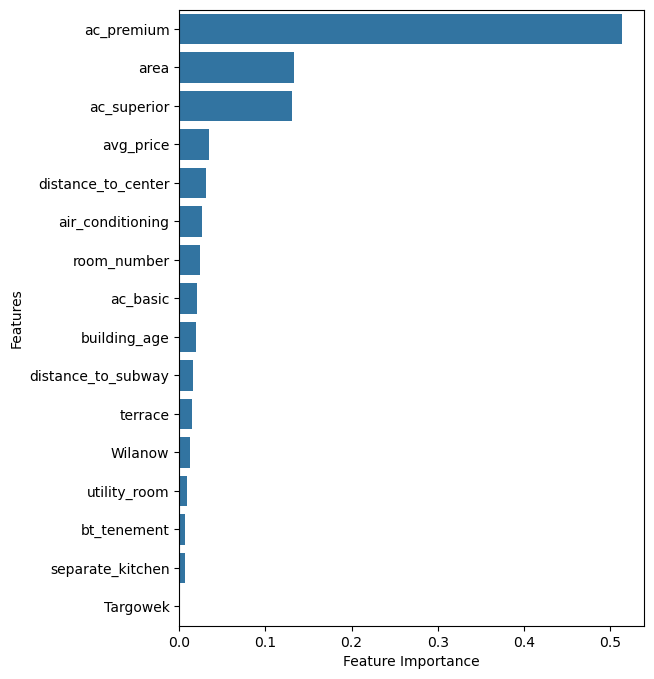

In [186]:
importances = pd.Series(best_model.feature_importances_, index=selected_features)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(6, 8))
sns.barplot(x=importances, y=importances.index,)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

__Drop-out Loss plots__

In [188]:
explainer = dx.Explainer(
    model=best_model,
    data=X_train[selected_features],
    y=y_train,
    label="XGBoost Regressor",
    verbose=False
)

Basic drop-out loss plot

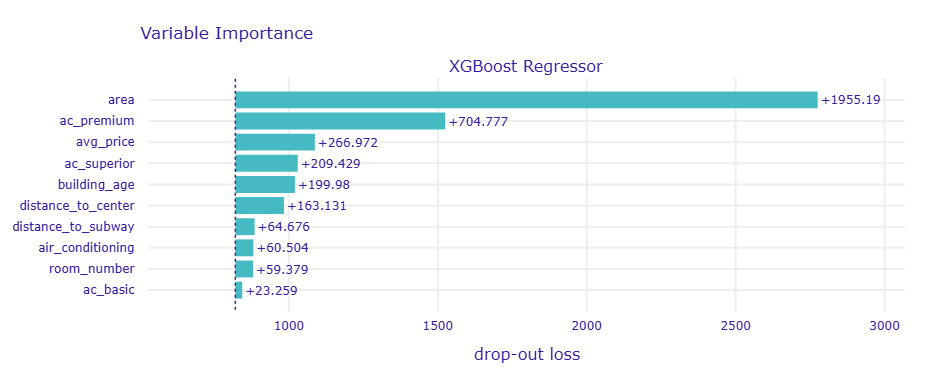

In [191]:
explainer.model_parts().plot()

Drop-out loss plot with grouped variables

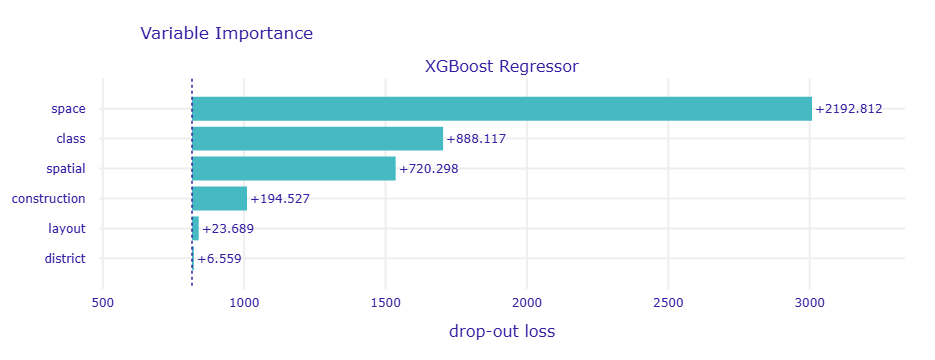

In [193]:
variable_groups = {
    'space': ['area', 'room_number'],
    'layout': ['terrace', 'separate_kitchen', 'utility_room'],
    'construction': ['building_age', 'bt_tenement'],
    'spatial': ['distance_to_center', 'distance_to_subway', 'avg_price'],
    'district': ['Targowek', 'Wilanow'],
    'class': ['ac_premium', 'ac_superior', 'ac_basic']}

explainer.model_parts(variable_groups=variable_groups).plot()

Drop-out loss plot including aspects

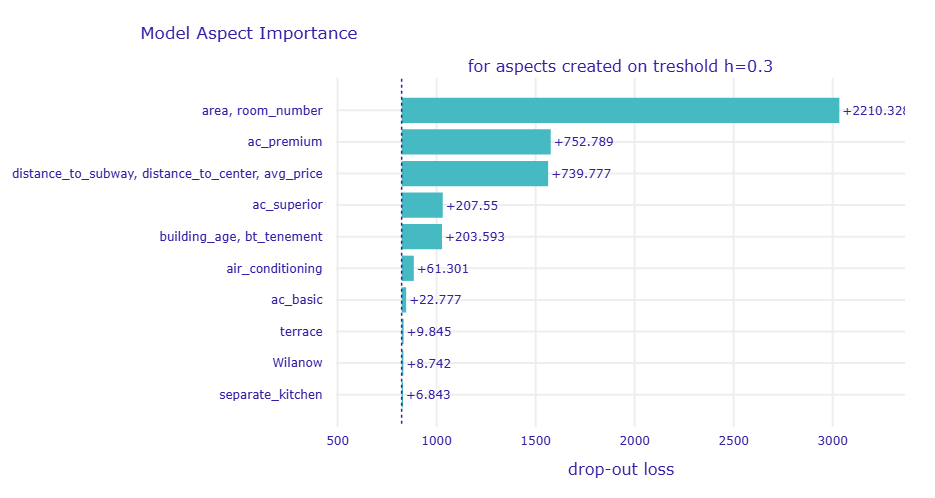

In [195]:
asp = dx.Aspect(explainer)
asp.model_parts(h=0.3, label='for aspects created on treshold h=0.3').plot()

__SHAP Tree Explainer - Train Sample__

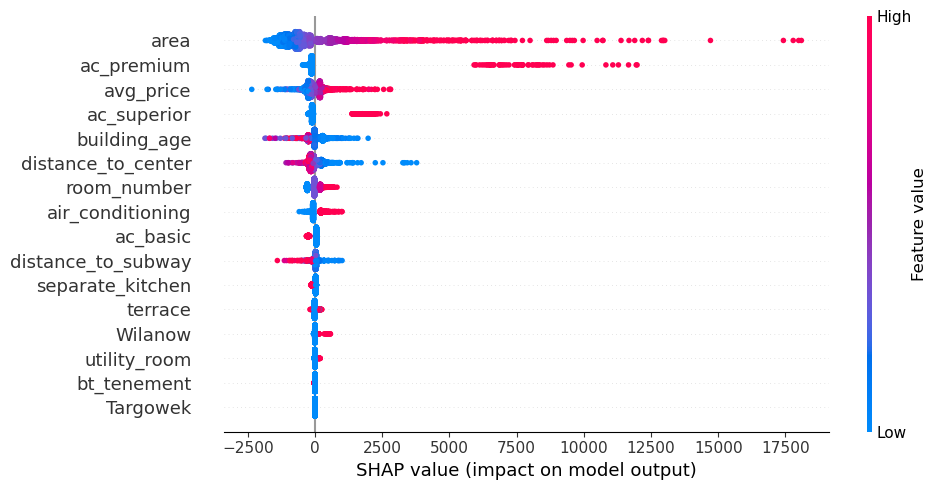

In [197]:
shap_explainer = shap.TreeExplainer(best_model)

shap_values_train = shap_explainer.shap_values(X_train[selected_features])
shap.summary_plot(shap_values_train, X_train[selected_features], plot_size=(10, 5))

__SHAP Tree Explainer - Out of time__

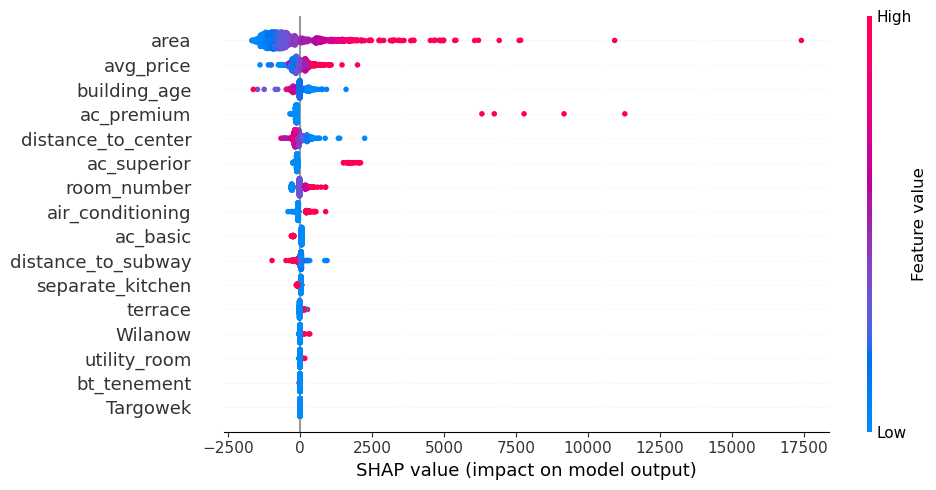

In [199]:
shap_values_oot = shap_explainer.shap_values(X_out_of_time[selected_features])
shap.summary_plot(shap_values_oot, X_out_of_time[selected_features], plot_size=(10, 5))

In [97]:
selected_features

Index(['area', 'room_number', 'terrace', 'separate_kitchen', 'utility_room',
       'building_age', 'air_conditioning', 'distance_to_subway',
       'distance_to_center', 'avg_price', 'bt_tenement', 'ac_basic',
       'ac_premium', 'ac_superior', 'Targowek', 'Wilanow'],
      dtype='object')

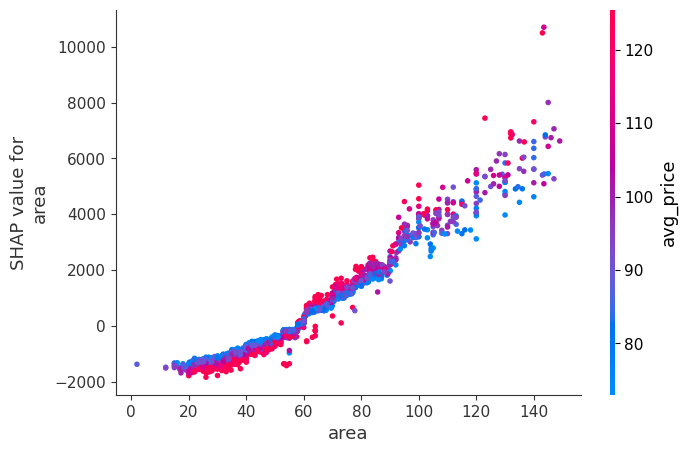

In [227]:
area_mask = X_train['area'] < 150
filtered_features = X_train[selected_features][area_mask]
filtered_shap_values = shap_values_train[area_mask]

shap.dependence_plot("area", filtered_shap_values, filtered_features, interaction_index="avg_price")

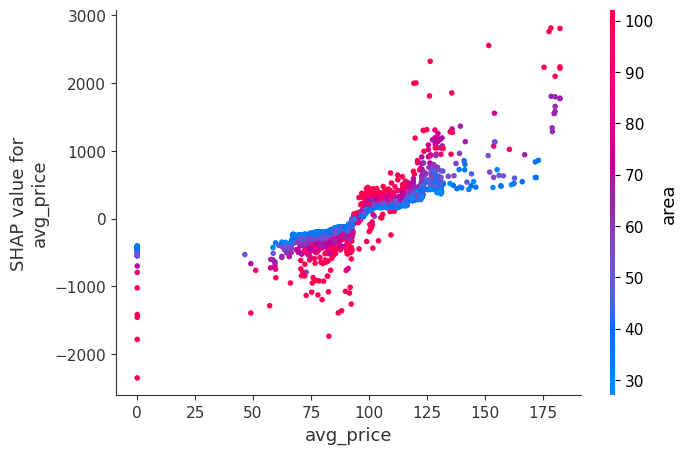

In [223]:
shap.dependence_plot("avg_price", shap_values_train, X_train[selected_features], interaction_index="area")

### Hypothesis 1

__The rental market exhibits a synergistic interaction between apartment class and proximity to the city center, where:__<br>
(a) Higher apartment classes (premium/superior) command disproportionately larger price premiums in central locations compared to peripheral areas,<br>
(b) Proximity to the center amplifies the price premium of higher apartment classes more than it benefits lower classes.

In [306]:
shap_explainer = shap.TreeExplainer(best_model)
shap_values_train = shap_explainer.shap_values(X_train[selected_features])

apartment_classes = ['ac_basic', 'ac_superior', 'ac_premium']
results = []
for ac in apartment_classes:
    ac_idx = selected_features.get_loc(ac)
    ac_shap = shap_values_train[:, ac_idx]
    
    central_mask = X_train.distance_to_center.le(1)&X_train[ac].eq(1)
    non_central_mask = X_train.distance_to_center.gt(1)&X_train[ac].eq(1)
    central_shap = ac_shap[central_mask]
    non_central_shap = ac_shap[non_central_mask]
    
    results.append({
        'class': ac.replace('ac_', ''),
        'central_median_effect': np.median(central_shap),
        'non_central_median_effect': np.median(non_central_shap),
        'effect_ratio': np.median(central_shap) / np.median(non_central_shap),
        'p_value (Mann-Whitney U test)': stats.mannwhitneyu(central_shap, non_central_shap, alternative='two-sided').pvalue
    })

result_df = pd.DataFrame(results).set_index('class')
print("Apartment Class - Price Impact Comparison:")
result_df.reset_index()

Apartment Class - Price Impact Comparison:


,class,central_median_effect,non_central_median_effect,effect_ratio,p_value (Mann-Whitney U test)
0,basic,-289.975769,-250.375000,1.158166,6.061737e-12
1,superior,2142.194092,1750.057007,1.224071,1.741348e-07
2,premium,7719.238281,6965.533691,1.108205,5.290291e-04


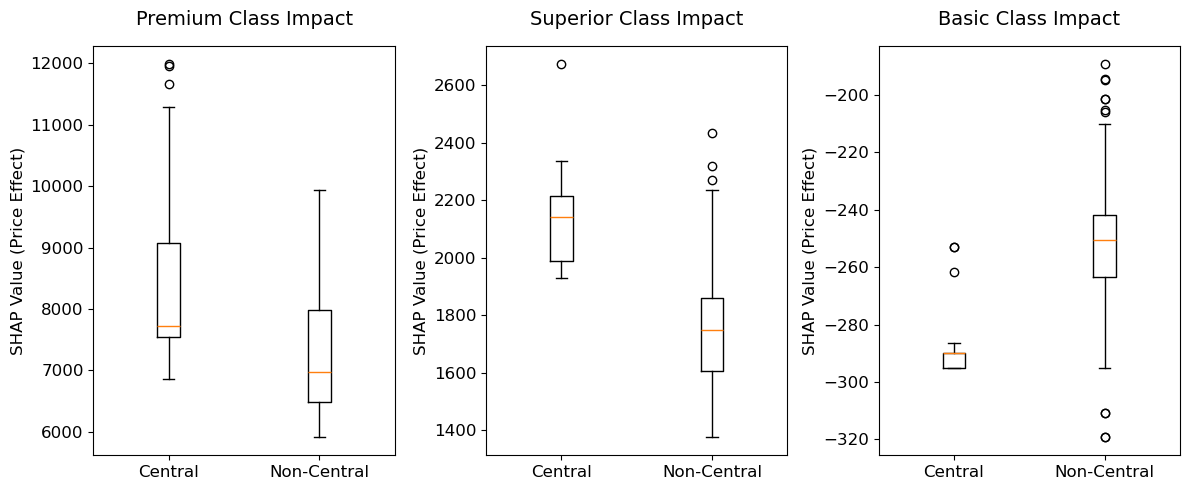

In [298]:
plt.figure(figsize=(12, 5))

for i, ac in enumerate(['ac_premium', 'ac_superior', 'ac_basic']):
    ac_idx = selected_features.get_loc(ac)
    plt.subplot(1, 3, i+1)
    
    central_mask = X_train.distance_to_center.le(1) & X_train[ac].eq(1)
    non_central_mask = X_train.distance_to_center.gt(1) & X_train[ac].eq(1)
    
    plt.boxplot([
        shap_values_train[central_mask, ac_idx],
        shap_values_train[non_central_mask, ac_idx]
    ], labels=['Central', 'Non-Central'])
    
    plt.title(f"{ac.replace('ac_', '').title()} Class Impact", fontsize=14, pad=15)
    plt.ylabel('SHAP Value (Price Effect)', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

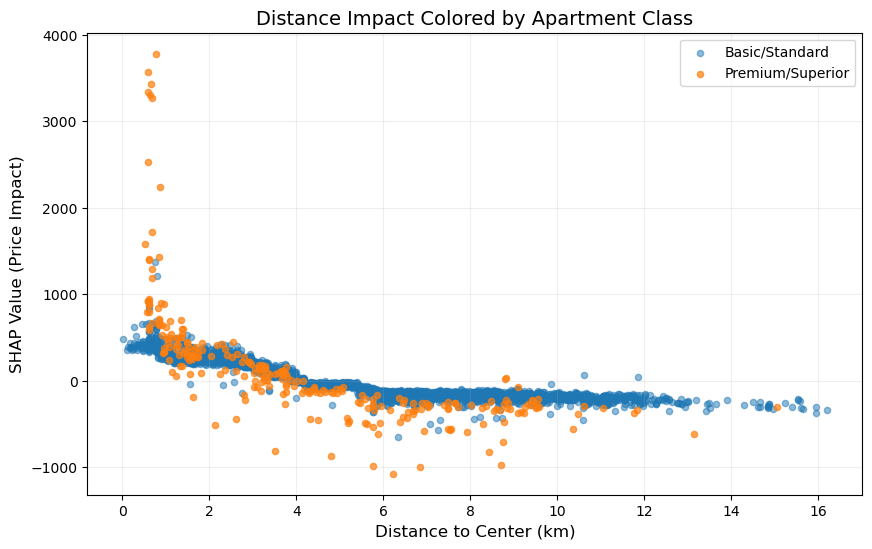

In [342]:
distance_values = X_train['distance_to_center'].values
shap_values = shap_values_train[:, selected_features.get_loc('distance_to_center')]
premium_mask = (X_train['ac_premium'] == 1) | (X_train['ac_superior'] == 1)
plt.figure(figsize=(10, 6))

# Plot non-premium points
plt.scatter(
    distance_values[~premium_mask],
    shap_values[~premium_mask],
    c='#1f77b4',
    s=20,
    alpha=0.5,
    label='Basic/Standard'
)

# Plot premium/superior points
plt.scatter(
    distance_values[premium_mask],
    shap_values[premium_mask],
    c='#ff7f0e',
    s=20,
    alpha=0.7,
    label='Premium/Superior'
)

plt.xlabel("Distance to Center (km)", fontsize=12)
plt.ylabel("SHAP Value (Price Impact)", fontsize=12)
plt.title("Distance Impact Colored by Apartment Class", fontsize=14)
plt.legend()
plt.grid(alpha=0.2)
plt.show()

In [395]:
X_train.area.describe()

count    3610.000000
mean       53.663623
std        26.716654
min         2.000000
25%        38.000000
50%        48.000000
75%        60.275000
max       350.000000
Name: area, dtype: float64

### Area

Calculating ceteris paribus: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]


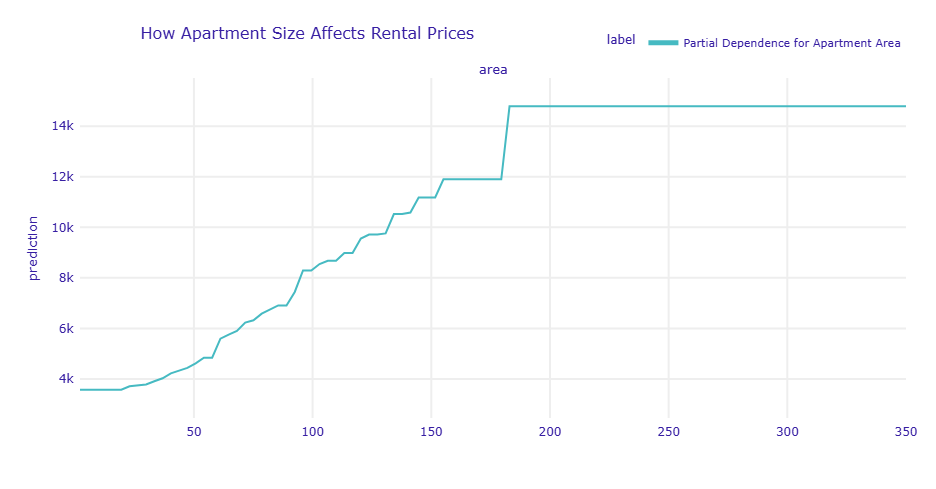

IndexError: list index out of range

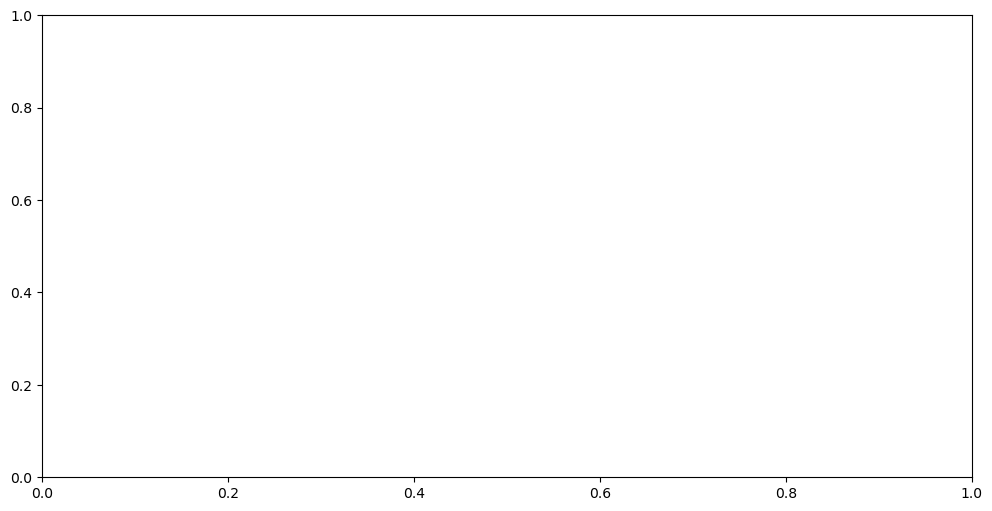

In [393]:
pdp_area = explainer.model_profile(
    variables=["area"],
    N=100,
    type="partial",
    label="Partial Dependence for Apartment Area"
)

# Customize and plot using proper parameters
plt.figure(figsize=(12, 6))
pdp_area.plot(
    title="How Apartment Size Affects Rental Prices",
)

# Post-plot customization using matplotlib
ax = plt.gca()
lines = ax.get_lines()
lines[0].set_linewidth(2.5)  # Directly set linewidth via matplotlib

plt.xlabel("Area (sqm)", fontsize=12)
plt.ylabel("Predicted Price Impact (PLN)", fontsize=12)
plt.grid(alpha=0.2)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.show()

__Ceteris Paribus plots - Train Sample__

Preparation of a new explainer is initiated

  -> data              : 3610 rows 16 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3610 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : XGBoost Model
  -> predict function  : <function yhat_default at 0x000001EF223E3C40> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 2.24e+03, mean = 5.07e+03, max = 4.52e+04
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -5.33e+03, mean = -0.146, max = 7.44e+03
  -> model_info        : package xgboost

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 6/6 [00:00<00:00, 205.17it/s]


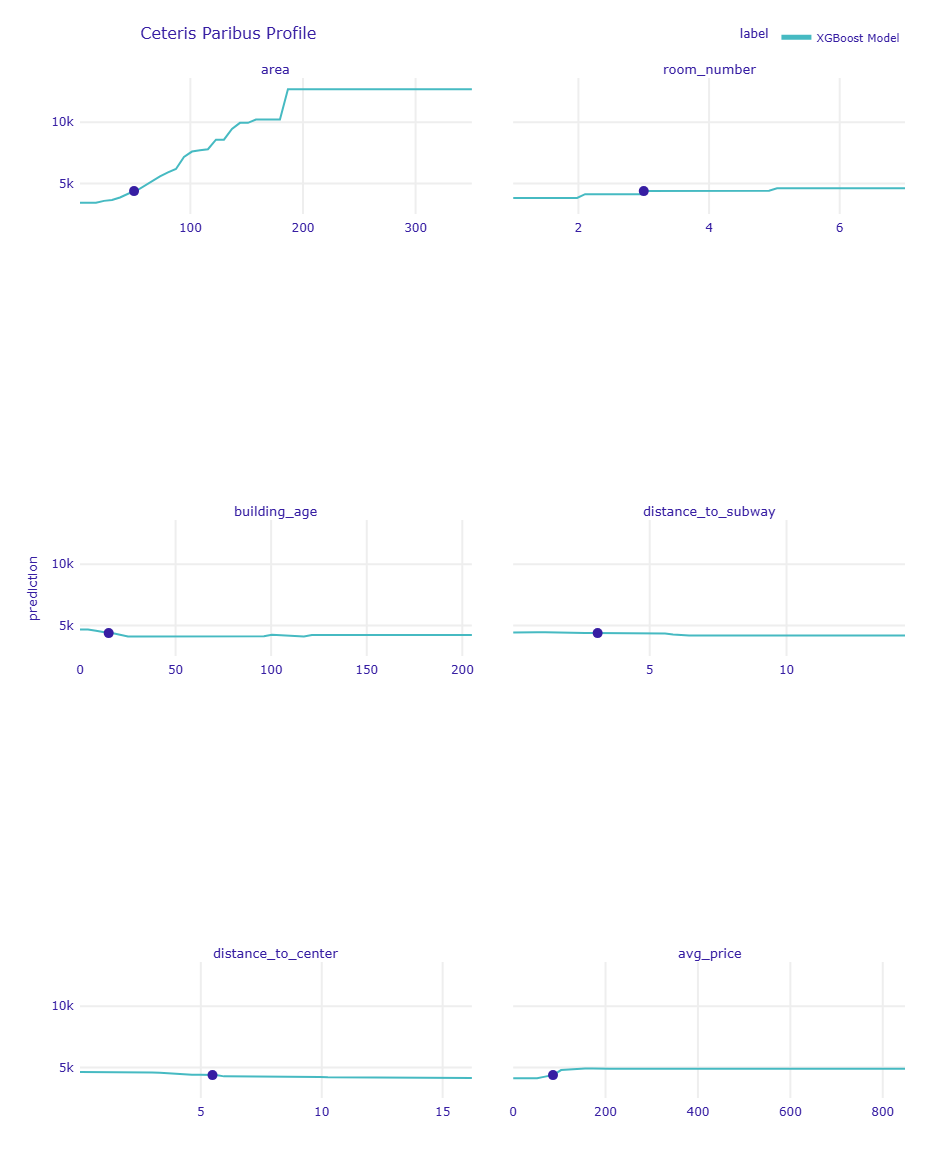

In [163]:
variables = ['area', 'room_number', 'building_age', 'distance_to_subway', 'distance_to_center', 'avg_price']
# 1. Create explainer
explainer = dx.Explainer(
    best_model,  # your trained model
    X_train[selected_features],  # your features
    y_train,  # your target
    label="XGBoost Model"  # optional label
)

# 2. Select observation(s) to analyze
selected_observation = X_train[selected_features].iloc[[150]]  # First observation

# 3. Create ceteris paribus profile
cp_profile = explainer.predict_profile(
    selected_observation,
    variables=variables,  
    grid_points=50  # number of points in grid
)

# 4. Plot the results
cp_profile.plot(
    variables=None,  # None for all variables, or list of specific ones
    title="Ceteris Paribus Profile",
    vertical_spacing=0.3,
    show=False
)